In [ ]:
!pip install gdown

In [ ]:
!gdown 1dOdUmnKCOj1t0THEtOHBzA1txrUQCM8D

Downloading...
From (original): https://drive.google.com/uc?id=1dOdUmnKCOj1t0THEtOHBzA1txrUQCM8D
From (redirected): https://drive.google.com/uc?id=1dOdUmnKCOj1t0THEtOHBzA1txrUQCM8D&confirm=t&uuid=d767cca5-2109-4cbf-afed-0c74150c51f8
To: /content/archive.zip
100% 8.77G/8.77G [02:07<00:00, 68.8MB/s]


In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [ ]:
#cài thư viện
!pip install sentence-transformers #=> Embedding câu chữ
!pip install faiss-gpu #=>Dựng lên một vector DB để tìm kiếm trong DB đó

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.1 MB/s eta 0:00:00


In [ ]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


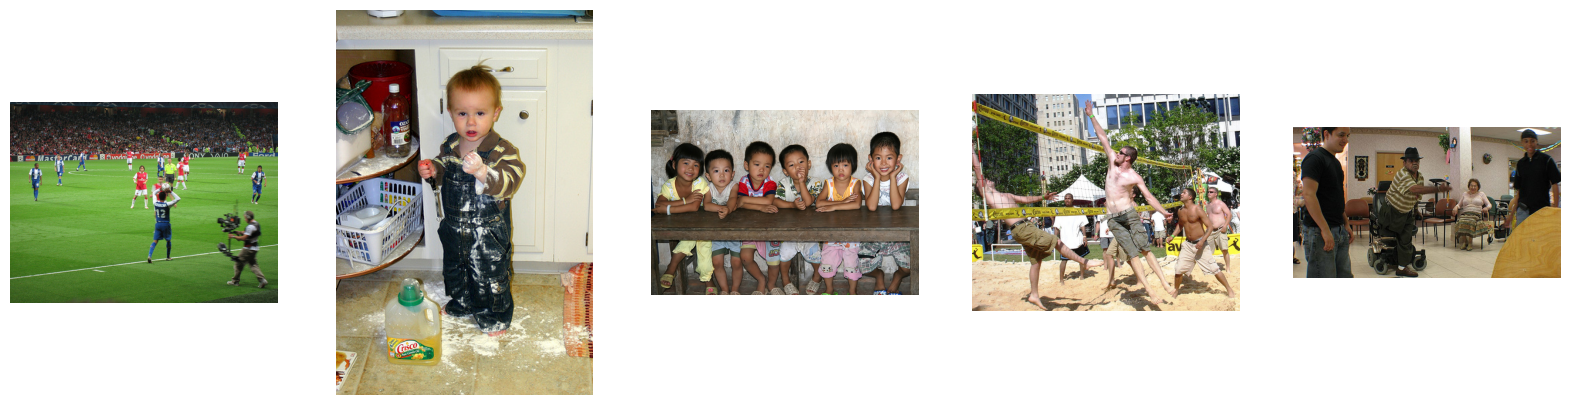

In [ ]:
#Show thử một vài hình ảnh trong bộ dữ liệu
image_folder = "/content/flickr30k_images/flickr30k_images"

#Lấy danh sách file trong thư mục hình ảnh
image_files = glob(os.path.join(image_folder, "*.jpg"))

#Chọn ngẫu nhiên 5 hình ảnh
selected_files = random.sample(image_files, 5)

plt.figure(figsize=(20, 5))

for i, file in enumerate(selected_files):
    image = Image.open(file)
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

In [ ]:
#Tạo embedding cho 30k ảnh bằng model
model = SentenceTransformer('clip-ViT-B-32')
image_path = "/content/flickr30k_images/flickr30k_images"
image_files = glob(os.path.join(image_path, "*.jpg")) #duyệt qua các ảnh trong link
chunk_size = 256
embeddings = []

def process_chunk(chunk):
  images = []
  for image_file in chunk:
    images.append(Image.open(image_file))

  chunk_embeddings = model.encode(images)
  return chunk_embeddings

# for image_file in image_files:
#     image = Image.open(image_file)
#     image_embedding = model.encode(image)
#     embeddings.append(image_embedding)

for i in range(0, len(image_files), chunk_size):
  print(i)
  chunk = image_files[i: i + chunk_size]
  embeddings.extend(process_chunk(chunk))

0
256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840
4096
4352
4608
4864
5120
5376
5632
5888
6144
6400
6656
6912
7168
7424
7680
7936
8192
8448
8704
8960
9216
9472
9728
9984
10240
10496
10752
11008
11264
11520
11776
12032
12288
12544
12800
13056
13312
13568
13824
14080
14336
14592
14848
15104
15360
15616
15872
16128
16384
16640
16896
17152
17408
17664
17920
18176
18432
18688
18944
19200
19456
19712
19968
20224
20480
20736
20992
21248
21504
21760
22016
22272
22528
22784
23040
23296
23552
23808
24064
24320
24576
24832
25088
25344
25600
25856
26112
26368
26624
26880
27136
27392
27648
27904
28160
28416
28672
28928
29184
29440
29696
29952
30208
30464
30720
30976
31232
31488
31744


In [ ]:
#Dựng lên vectorDB với FAISS
dimension = len(embeddings[0])
index = faiss.IndexFlatIP(dimension)
index = faiss.IndexIDMap(index)

vectors = np.array(embeddings).astype("float32")
index.add_with_ids(vectors, np.array(range(0, len(embeddings))))

#Save index vào file
faiss.write_index(index, "index.faiss")

#Ghi các tên ảnh vào tệp tin để load khi cần
with open("image_files.txt", "w") as f:
  for image_file in image_files:
    f.write(image_file + "\n")

In [ ]:
def search_image(query, model, index, image_files, top_k=5):
  #Query có thể là ảnh hoặc text
  if query.endswith(".jpg"):
    query_image = Image.open(query)

  query_embedding = model.encode(query)
  query_embedding = query_embedding.astype("float32").reshape(1, -1)

  distances, indices = index.search(query_embedding, top_k) #Trả ra khoảng cách, thứ tự

  retrieved_image_files = [image_files[i] for i in indices[0]]

  return query, retrieved_image_files

In [ ]:
# Visualize retrieved_image_files
def visualize_results(query, retrieved_images):
  plt.figure(figsize=(20, 5))

  #if image query
  if isinstance(query, Image.Image):
    plt.subplot(1, len(retrieved_images), 1)
    plt.imshow(query)
    plt.axis("off")
    plt.title("Query image")
    start_inx = 2
  #if text query
  else:
    plt.subplot(1, len(retrieved_images) + 1, 1)
    plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
    plt.axis("off")
    start_inx = 2

  #Display images
  for i, img_path in enumerate(retrieved_images):
    plt.subplot(1, len(retrieved_images) + 1, i + start_inx)
    plt.imshow(Image.open(img_path))
    plt.title(f"Match: {i+1}")
    plt.axis("off")

  plt.show()

In [ ]:
#Tìm kiếm từ text
query = "Dog is eating apple"
query, retrieved_image_files = search_image(query, model, index, image_files)

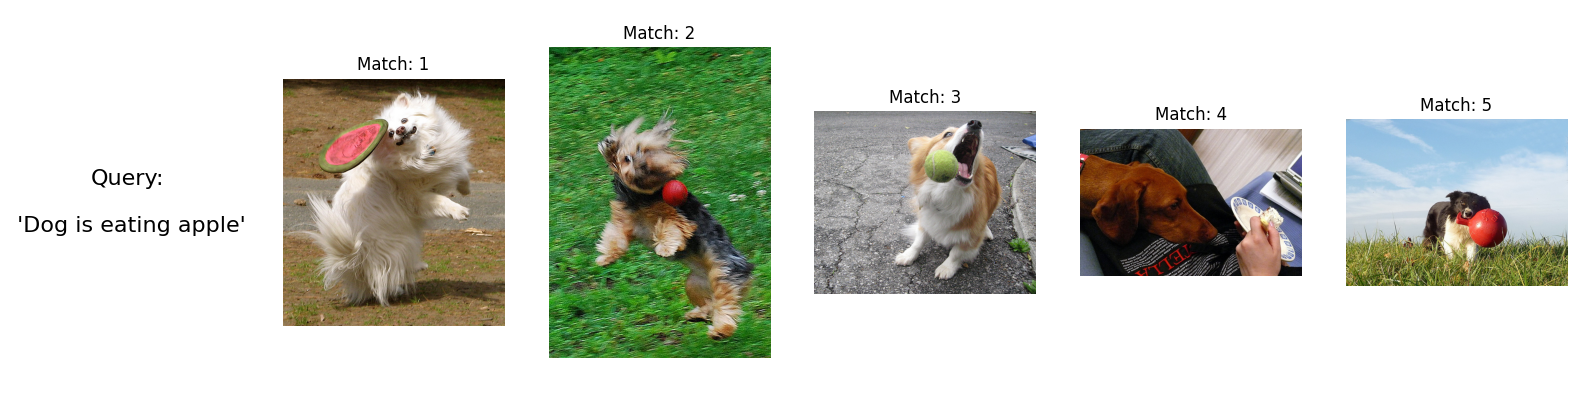

In [ ]:
visualize_results(query, retrieved_image_files)

In [ ]:
!pip install translate

In [ ]:
from translate import Translator

def translate_text(text, src_lang='vi', dest_lang='en'):
    translator = Translator(from_lang=src_lang, to_lang=dest_lang)
    translation = translator.translate(text)
    return translation

# Ví dụ sử dụng
input_text = "em bé và mẹ đang nằm trên gường ngủ"
query = translate_text(input_text)
query, retrieved_image_files = search_image(query, model, index, image_files)


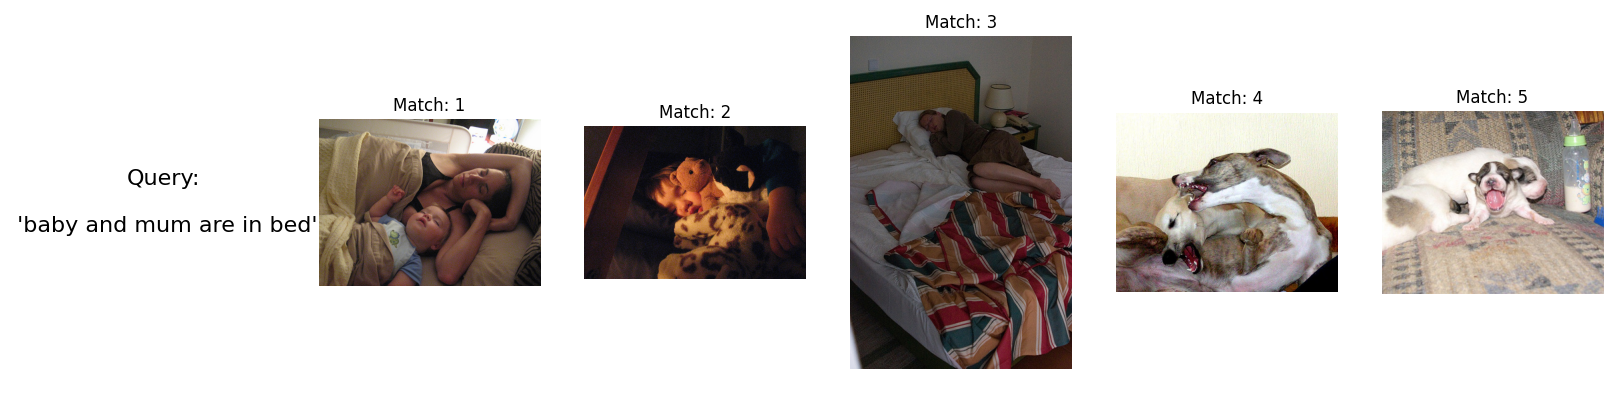

In [ ]:
visualize_results(query, retrieved_image_files)